# Group 5 - Module 2: Recommendation Systems

***
## Group Members:
* ### Nils Dunlop, 20010127-2359, Applied Data Science, e-mail: gusdunlni@student.gu.se (16 hours)
* ### Francisco Alejandro Erazo Piza, 19930613-9214, Applied Data Science, e-mail: guserafr@student.gu.se (16 hours)

#### **We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions." (This is independent and additional to any declaration that you may encounter in the electronic submission system.)**

# Assignment 3
***

## Problem 1: Reading and Reflection From The Hidden Technical Debt in Machine Learning Systems paper.
***

### Key Takeaways:
- **Complexity and Maintenance Costs:** Machine learning systems present unique challenges in software engineering such as notable high maintenance costs and complexity due to ML-specific issues leading to technical debt.
- **System-Level Issues:** The paper outlines system-level issues like boundary erosion, entanglement, hidden feedback loops, undeclared consumers, and data dependencies that contribute significantly to technical debt in ML systems.
- **Data Dependencies:** Data dependencies in ML systems are harder to detect and manage which could lead to unstable and underutilized data dependencies that increase technical debt.
- **Feedback Loops and Anti-Patterns:** Feedback loops can influence ML system behavior which can complicate maintenance. The paper also identifies system design anti-patterns such as glue code, pipeline jungles, dead experimental codepaths, and abstraction debt which can exacerbate technical debt.
- **Configuration Debt:** The configuration of ML systems can become complex and error-prone which can contribute to technical debt.

### Design Features:
- **Awareness and Mitigation:** Awareness of technical debt and proactive mitigation strategies are essential for maintaining and evolving ML systems efficiently.
- **System Design Considerations:** The paper emphasizes the importance of considering ML-specific issues in system design to prevent the accrual of technical debt.
- **Cultural Shift in ML Teams:** Encourages a cultural shift in ML teams to prioritize technical debt reduction alongside model accuracy improvements for the long-term health of ML systems.

## Problem 2: Implementation
***

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import mode
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

df_beijing = pd.read_csv('Beijing_labeled.csv')
df_chengdu = pd.read_csv('Chengdu_labeled.csv')
df_guangzhou = pd.read_csv('Guangzhou_labeled.csv')
df_shanghai = pd.read_csv('Shanghai_labeled.csv')
df_shenyang = pd.read_csv('Shenyang_labeled.csv')

df_beijing

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,cbwd_NE,cbwd_NW,cbwd_SE,PM_HIGH
0,4,-8.0,79.0,1026.0,-5.0,23.69,0.0,0,0,1,1.0
1,4,-11.0,85.0,1021.0,-9.0,105.93,1.1,0,0,1,0.0
2,4,-21.0,43.0,1030.0,-11.0,117.55,0.0,0,1,0,0.0
3,4,-25.0,33.0,1034.0,-12.0,39.35,0.0,1,0,0,0.0
4,4,-24.0,30.0,1034.0,-10.0,59.00,0.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2066,4,-15.0,45.0,1040.0,-5.0,1.79,0.0,0,1,0,0.0
2067,4,-13.0,34.0,1036.0,1.0,40.24,0.0,0,1,0,0.0
2068,4,-8.0,50.0,1028.0,1.0,1.79,0.0,0,1,0,1.0
2069,4,-11.0,28.0,1031.0,6.0,23.24,0.0,0,1,0,0.0


In [2]:
# Combine the datasets for Beijing, Chengdu, and Shenyang
df_combined = pd.concat([df_beijing, df_chengdu, df_shenyang], ignore_index=True)

# Reset the index to avoid any potential issues with non-sequential indices
df_combined.reset_index(drop=True, inplace=True)

# Split the combined dataset into features and target
X_combined = df_combined.drop(columns=['PM_HIGH'])
y_combined = df_combined['PM_HIGH']

# Split the combined dataset into training and validation sets
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42
)

# Prepare the testing sets for Guangzhou and Shanghai
X_test_guangzhou = df_guangzhou.drop(columns=['PM_HIGH']).reset_index(drop=True)
y_test_guangzhou = df_guangzhou['PM_HIGH'].reset_index(drop=True)

X_test_shanghai = df_shanghai.drop(columns=['PM_HIGH']).reset_index(drop=True)
y_test_shanghai = df_shanghai['PM_HIGH'].reset_index(drop=True)

In [3]:
class KMeansClassifier:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.labels_map = {}
        self.inertia_ = None

    def fit(self, X, y):
        # Fit the k-means algorithm to the data
        self.kmeans.fit(X)
        self.inertia_ = self.kmeans.inertia_

        # Predict the clusters
        clusters = self.kmeans.predict(X)

        # Create a mapping from each cluster to a label
        for cluster in range(self.n_clusters):
            cluster_indices = np.where(clusters == cluster)[0]
            cluster_labels = y.iloc[cluster_indices]
            majority_label = mode(cluster_labels, keepdims=False).mode

            # Ensure that majority_label is treated as an array
            if np.isscalar(majority_label):
                majority_label = np.array([majority_label])

            # Map the cluster to the majority label
            self.labels_map[cluster] = majority_label[0]

    def predict(self, X):
        # Find the nearest centroid for each point in X
        clusters = self.kmeans.predict(X)

        # Predict the label based on the nearest centroid
        predicted_labels = np.vectorize(self.labels_map.get)(clusters)
        return predicted_labels

    def score(self, X, y):
        # Predict the labels for X
        predicted_labels = self.predict(X)

        # Calculate the accuracy as the fraction of correctly predicted labels
        accuracy = np.mean(predicted_labels == y)
        return accuracy


In [4]:
# Initialize the classifier
# Optimal number of clusters was determined below to be 2
classifier = KMeansClassifier(n_clusters=2)

# Train the classifier on the combined training set
classifier.fit(X_train_combined, y_train_combined)

# Validate the classifier on the combined validation set
validation_accuracy = classifier.score(X_val_combined, y_val_combined)

# Evaluate on Guangzhou data
test_accuracy_guangzhou = classifier.score(X_test_guangzhou, y_test_guangzhou)

# Evaluate on Shanghai data
test_accuracy_shanghai = classifier.score(X_test_shanghai, y_test_shanghai)

print(f"Validation Accuracy (Beijing, Chengdu, Shenyang): {validation_accuracy:.2f}")
print(f"Test Accuracy for Guangzhou: {test_accuracy_guangzhou:.2f}")
print(f"Test Accuracy for Shanghai: {test_accuracy_shanghai:.2f}")

Validation Accuracy (Beijing, Chengdu, Shenyang): 0.73
Test Accuracy for Guangzhou: 0.94
Test Accuracy for Shanghai: 0.90


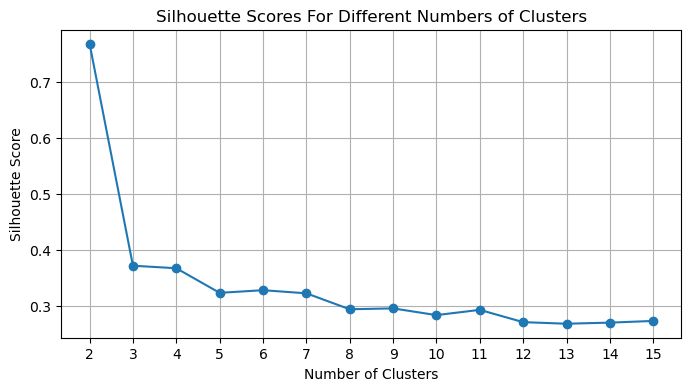

In [5]:
# Apply the silhouette score method
silhouette_scores = []
cluster_range = range(2, 16)

# Calculate the silhouette score for each number of clusters
for n_clusters in cluster_range:
    classifier = KMeansClassifier(n_clusters=n_clusters)
    classifier.fit(X_train_combined, y_train_combined)

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X_train_combined, classifier.kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores For Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

## Problem 3: Discussion
***

## References:
***

## Self Check
***
- Have you answered all questions to the best of your ability?
Yes, we have.
- Is all the required information on the front page, is the file name correct etc.?
Indeed, all the required information on the front page has been included.
- Anything else you can easily check? (details, terminology, arguments, clearly stated answers etc.?)
We have checked, and everything looks good.